In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import networkit as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import phate

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

from External.ICT.calculate_ICT import calculate_ICT, compute_widths
from External.clustering import k_means_pp
from External.generation import create_graph
from External.create_k_nearest import is_connected
from sklearn.metrics import pairwise_distances
from copy import deepcopy

from External.plotting import *

plt.style.use('standard.mplstyle')

# Hyperparameters
mode = "K_Nearest+Density2"
metric = "euclidean"
position, labels = phate.tree.gen_dla(n_dim=2, n_branch=3,
                                            branch_length=2500, rand_multiplier=2, seed=37, sigma=1)
position = StandardScaler().fit_transform(position)
number_of_nodes = len(position)

In [3]:
# Create the graph
G, position = create_graph(number_of_nodes, mode, position=position, beta=2, delta=0.5)
G.indexEdges()

Final k: 11


In [4]:
# calculate the clusters
ε, δ = 0.03, 0.1
r = 1 / (ε**2) * (int(np.log2(number_of_nodes - 1)) + 1 + np.log(1/δ))
k = int(np.sqrt(r))
k = np.min((k, G.numberOfNodes()))
cluster_centers = k_means_pp(k, position, metric=metric, G=G)

sklearn is done: 9.380115509033203
My own part is done: 0.04296469688415527


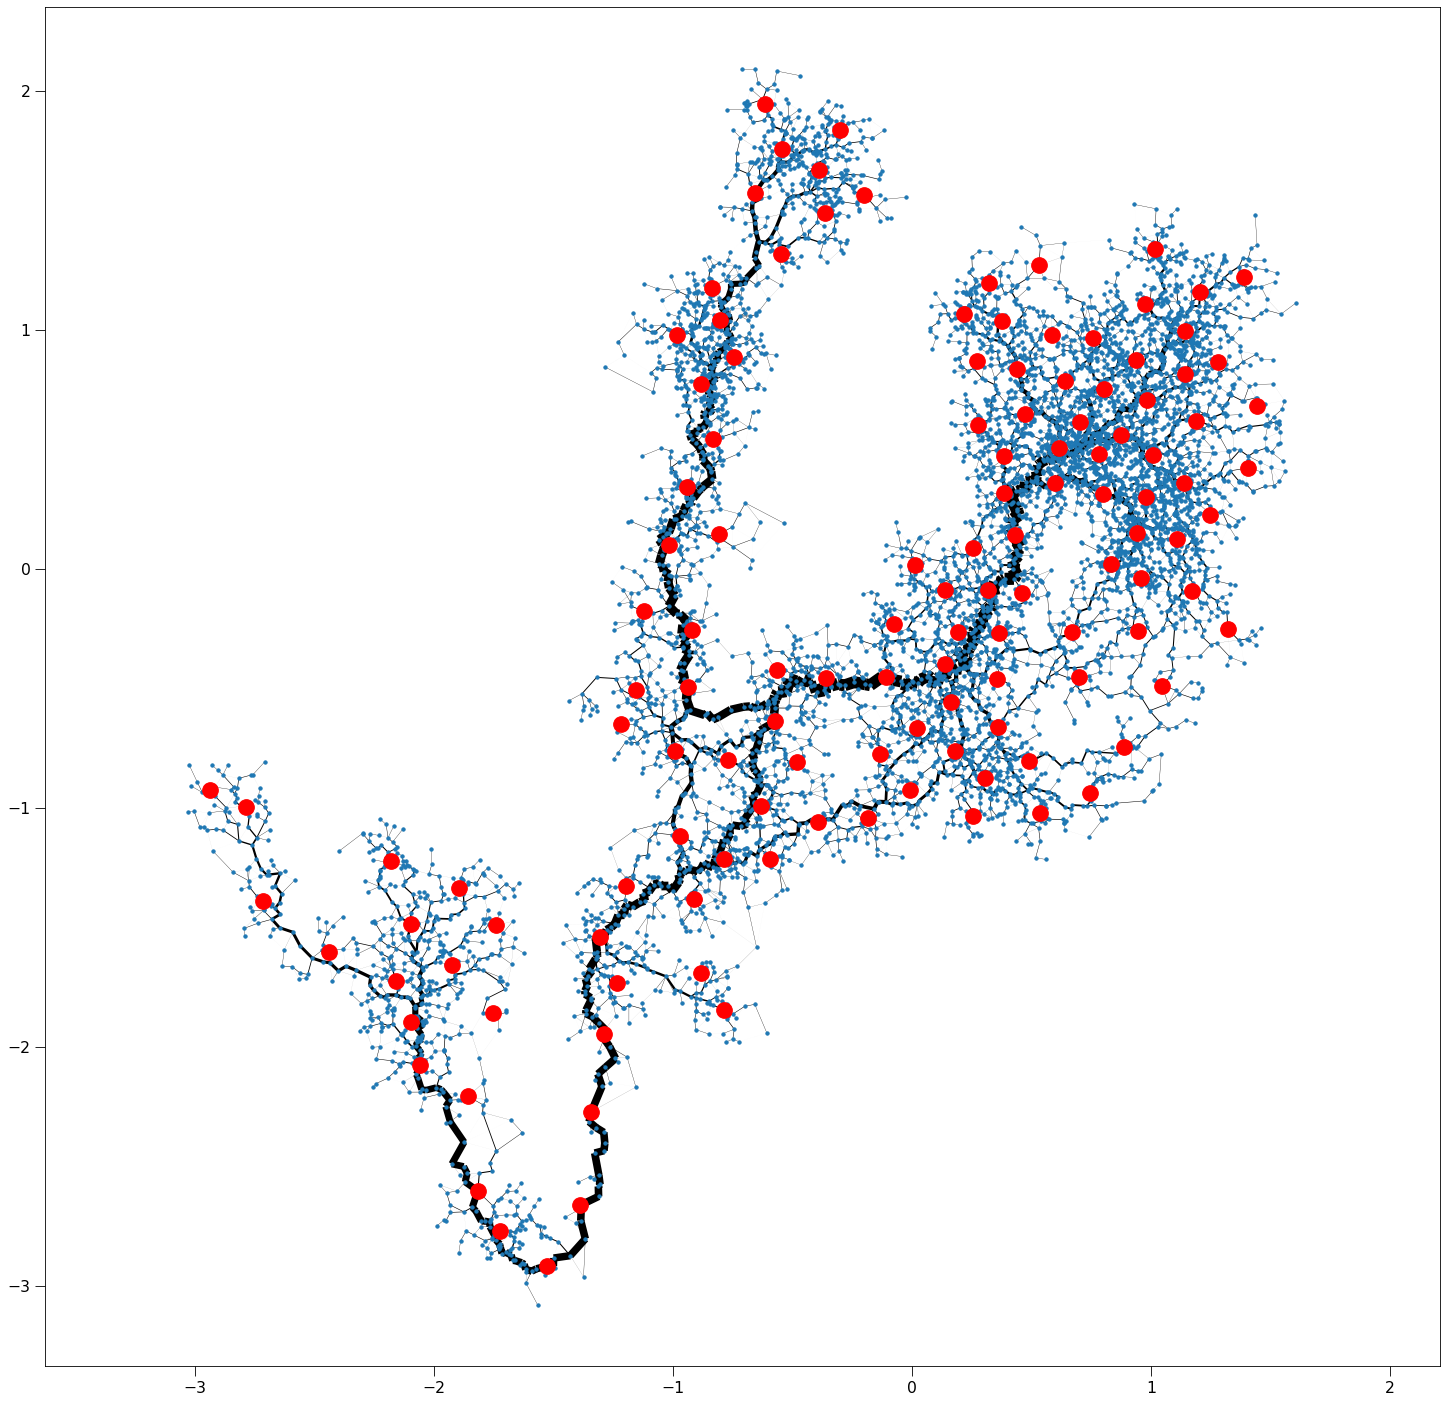

In [5]:
# plot the grahp
fig, ax = plt.subplots(1, figsize=(24,24))
nk.viztasks.drawGraph(G, pos=position, ax=ax, width=compute_widths(G), node_size=10)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.plot(*position[cluster_centers].T, marker="o", color = "Red")
ax.set_axis_on()
ax.axis("equal")
plt.show()

In [6]:
# calculate the cluster ICT with all aim nodes
start = time.time()
ICT_cluster_all = calculate_ICT(G, algorithm_type="cluster_all", cluster_centers=cluster_centers,
                                zeros_stay_zeros=True, update_G=1.1)
ICT_cluster_all.indexEdges()

# widths of the edges
widths_cluster_all = compute_widths(ICT_cluster_all)
print(time.time()-start)

update Arr 48410 -> 11846
added 263 edges early
update Arr 11846 -> 10768
added 322 edges early
update Arr 10768 -> 9787
added 288 edges early
update Arr 9787 -> 8897
added 406 edges early
update Arr 8897 -> 8087
added 508 edges early
update Arr 8087 -> 7499
added 446 edges early
added 3488 edges early

3407.253455877304


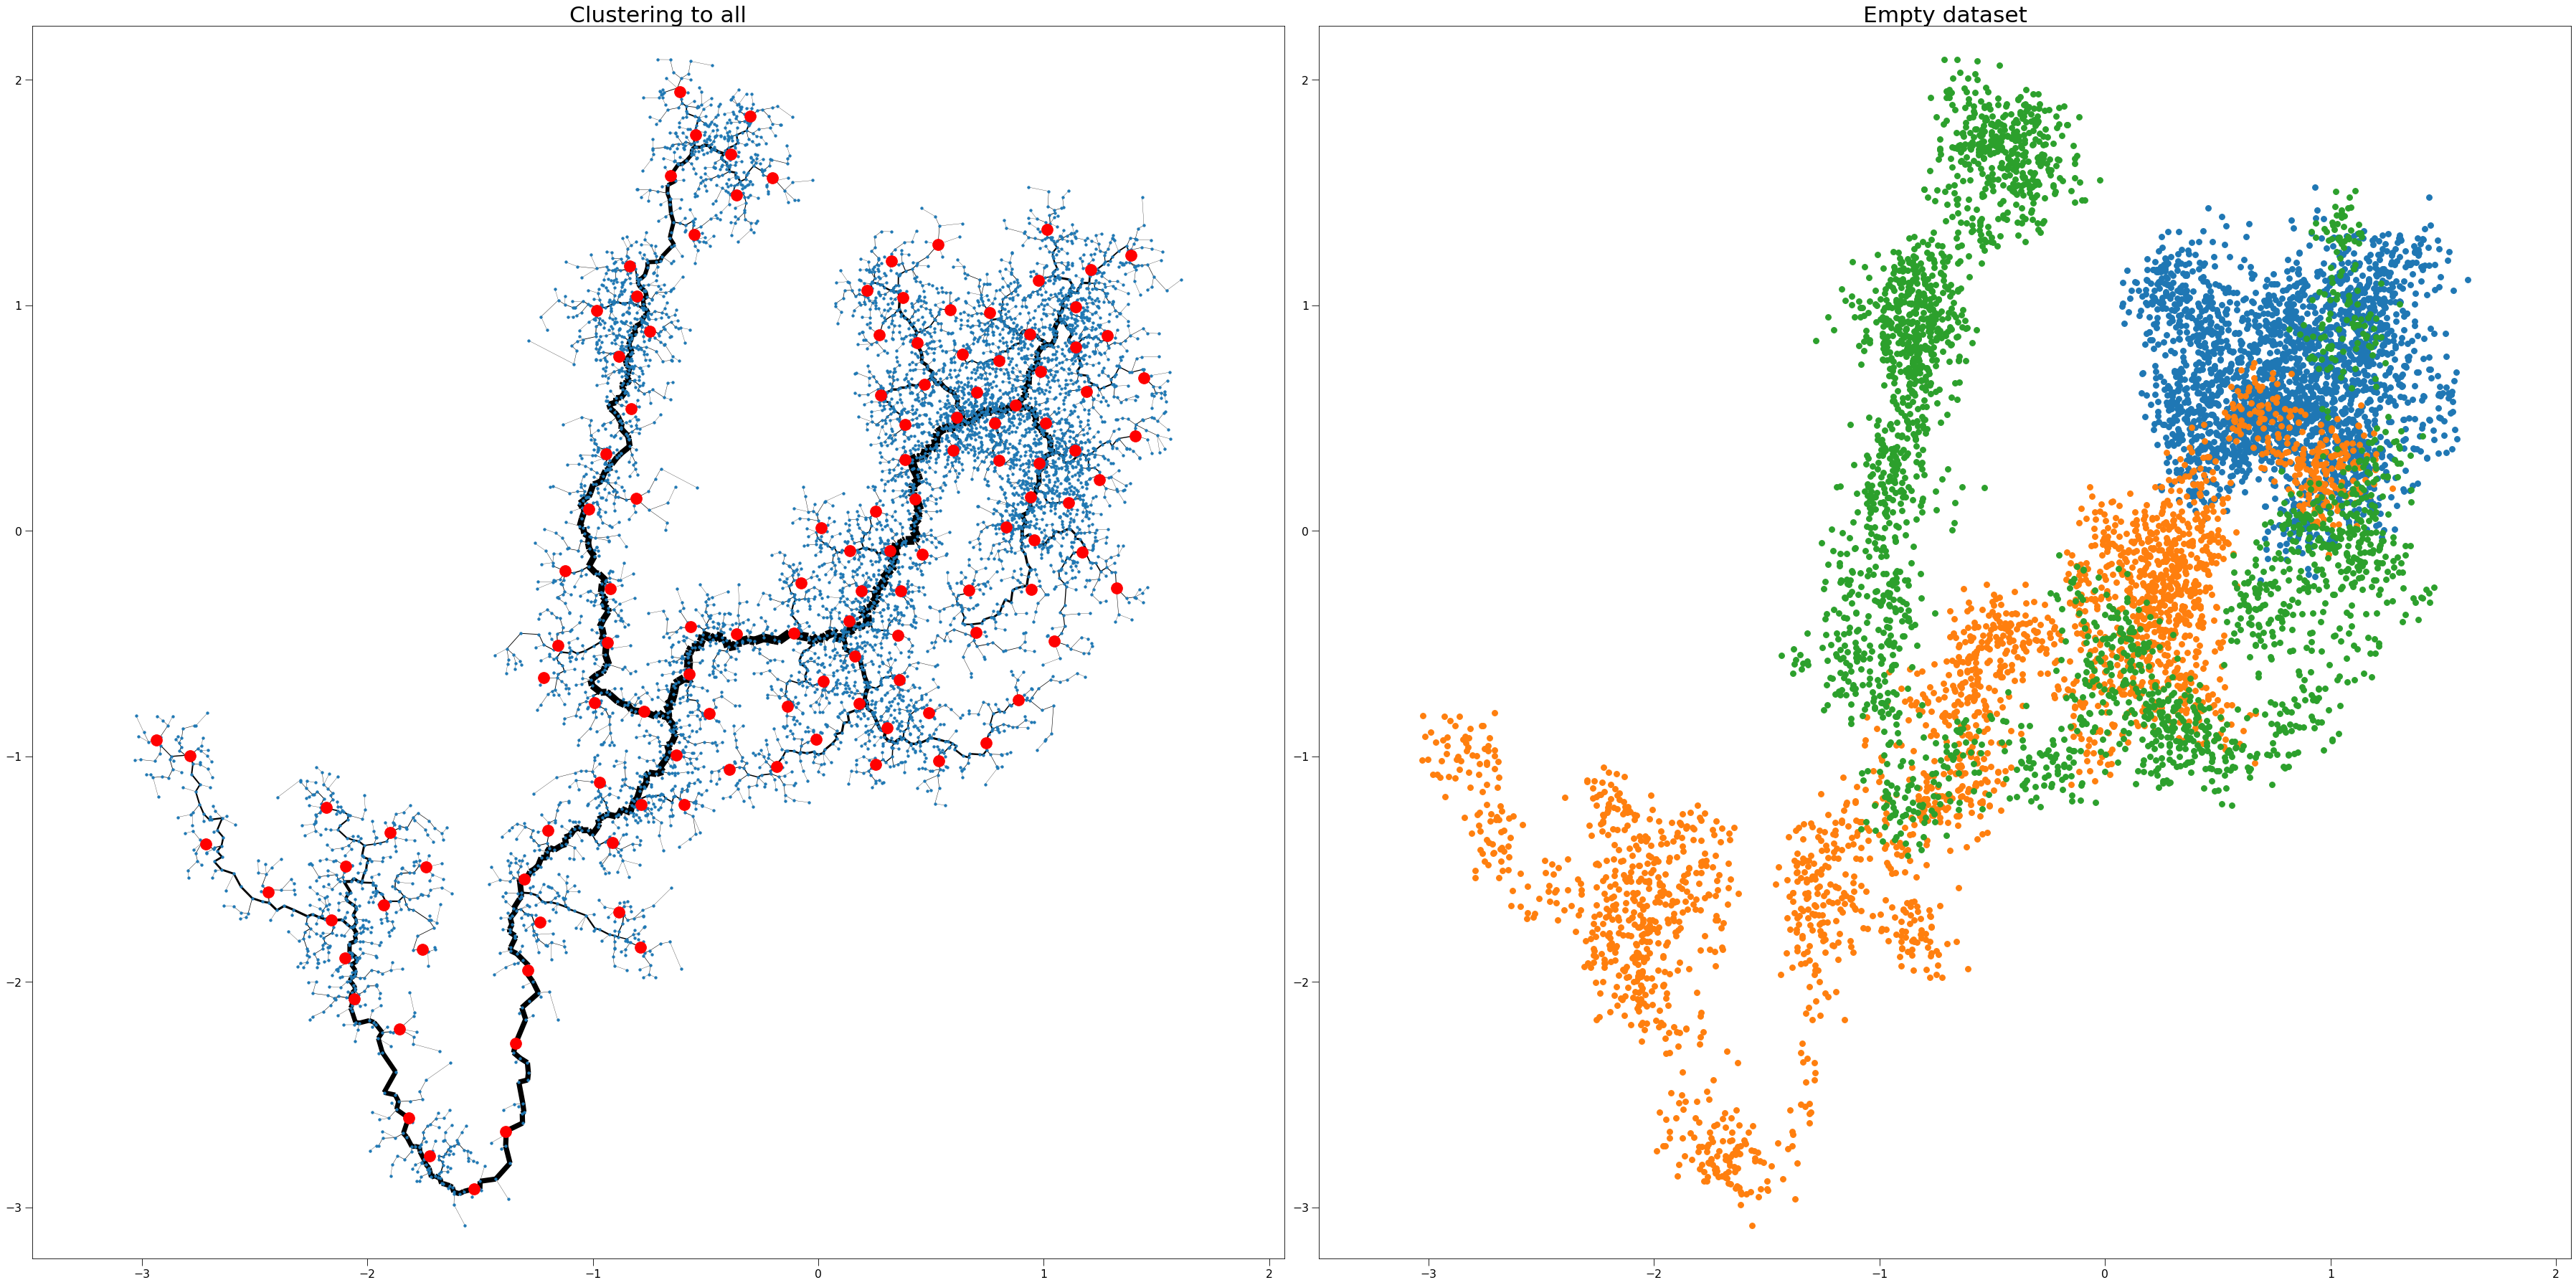

In [7]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Clustering to all", "Empty dataset"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=position, ax=ax[i], width=widths[i], node_size=10)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].plot(*position[cluster_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
    else:
        for label in range(len(labels)):
            plt.plot(*position[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.show()

In [8]:
DTAE_centers = k_means_pp(50, position, metric=metric, G=G)

sklearn is done: 5.12384557723999
My own part is done: 0.022817373275756836


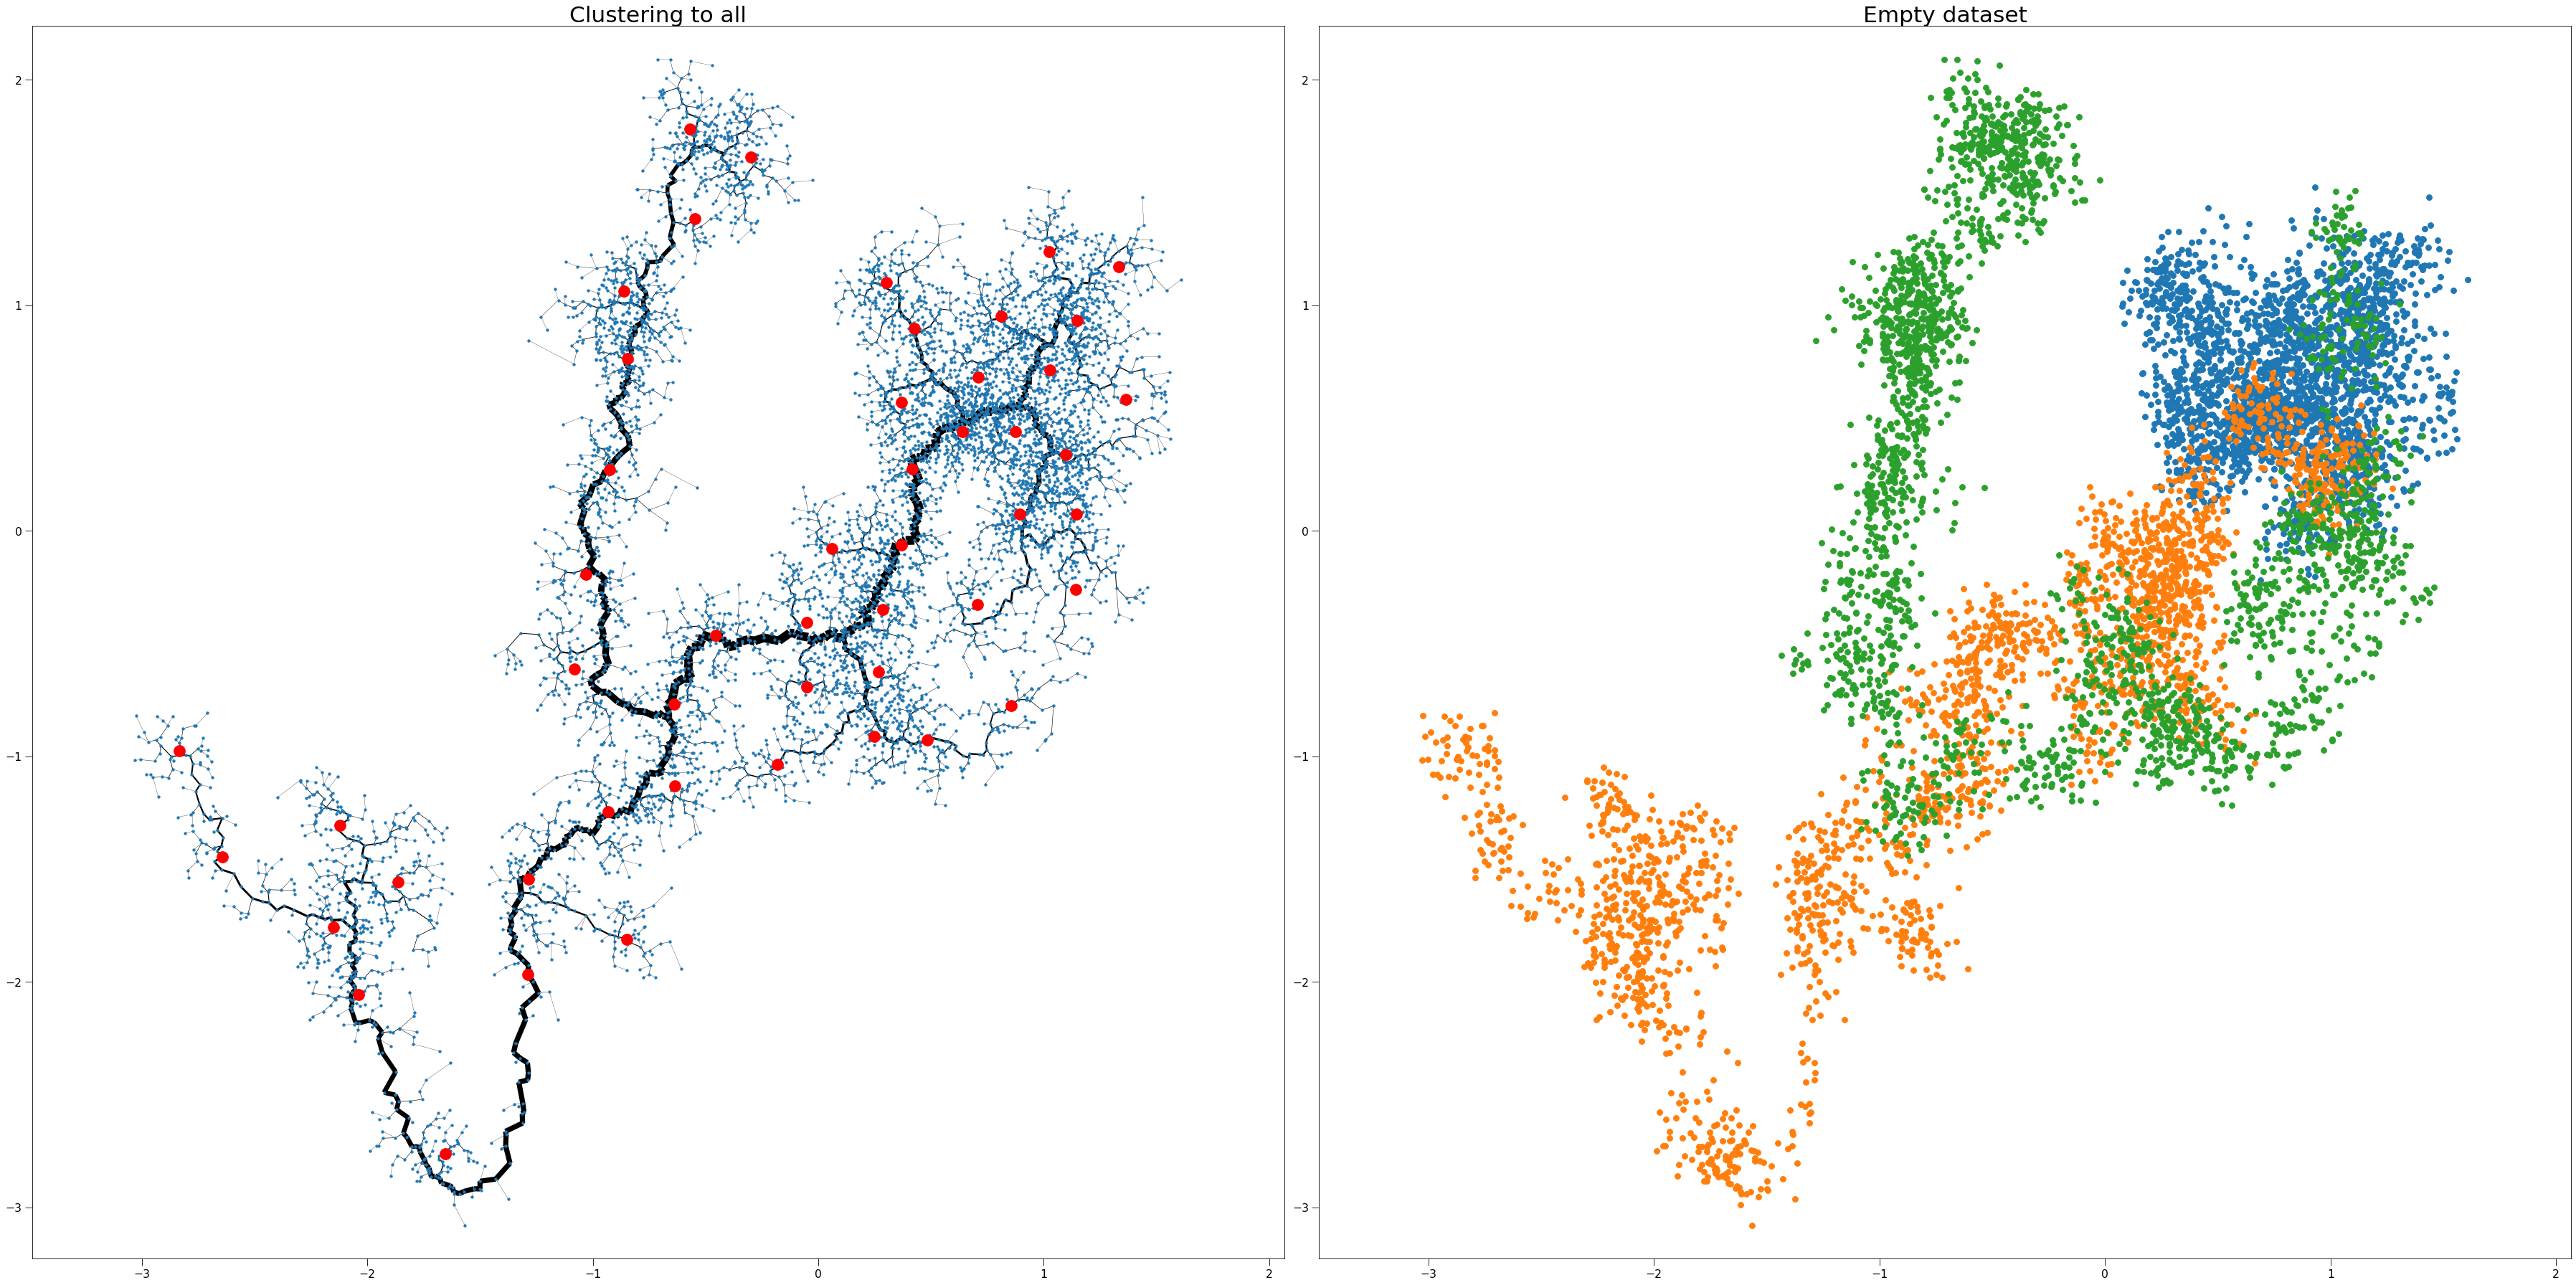

In [9]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Clustering to all", "Empty dataset"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=position, ax=ax[i], width=widths[i], node_size=10)
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].plot(*position[DTAE_centers].T, marker="o", color = "Red")
        ax[i].set_axis_on()
    else:
        for label in range(len(labels)):
            plt.plot(*position[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.show()

In [109]:
def find_tree(centers, ICT):
    
    graph = nk.graph.Graph(n=len(centers), weighted=True)
    
    distances = [[] for i in range(len(centers))]
    
    for i, source in enumerate(centers):
        Dijkstra = nk.distance.Dijkstra(G=G, source=source)
        Dijkstra.run()
        
        for target in centers:
            
            if target == source:
                
                # Later we are looking for the shortest distance
                # and we dont wont the trivial 0 distance!
                
                distances[i].append(np.inf)
                continue
                
            distances[i].append(Dijkstra.distance(target))
            
    distances = np.array(distances)
    
#     tree = nk.graph.Graph(n=len(centers), weighted=True)
    
#     indices = np.array(np.unravel_index(np.argsort(distances, axis=None), distances.shape)).T
    
#     components = [i for i in range(len(centers))]
    
#     components_bag = [[i] for i in range(len(centers))]
    
#     for u, v in indices:
#         if components[u] == components[v]:
#             continue
            
#         tree.addEdge(u, v, distances[u, v])
    
    
#         for node in components_bag[u]:
#             components_bag[v].append(node)
#             components[node] = components[v]

    for u in range(len(centers)):
        for v in range(len(centers)):
            if u == v:
                continue
            graph.addEdge(u, v, 1/distances[u, v])
            
    MST = nk.graph.RandomMaximumSpanningForest(graph)
    MST.run()
    mst = MST.getMSF(True)
    
    return mst

In [114]:
ICT = deepcopy(ICT_cluster_all)

dist = pairwise_distances(position)

for u, v, w in ICT.iterEdgesWeights():
    ICT.setWeight(u, v, dist[u, v])

mst = find_tree(DTAE_centers, ICT)

mst.indexEdges()

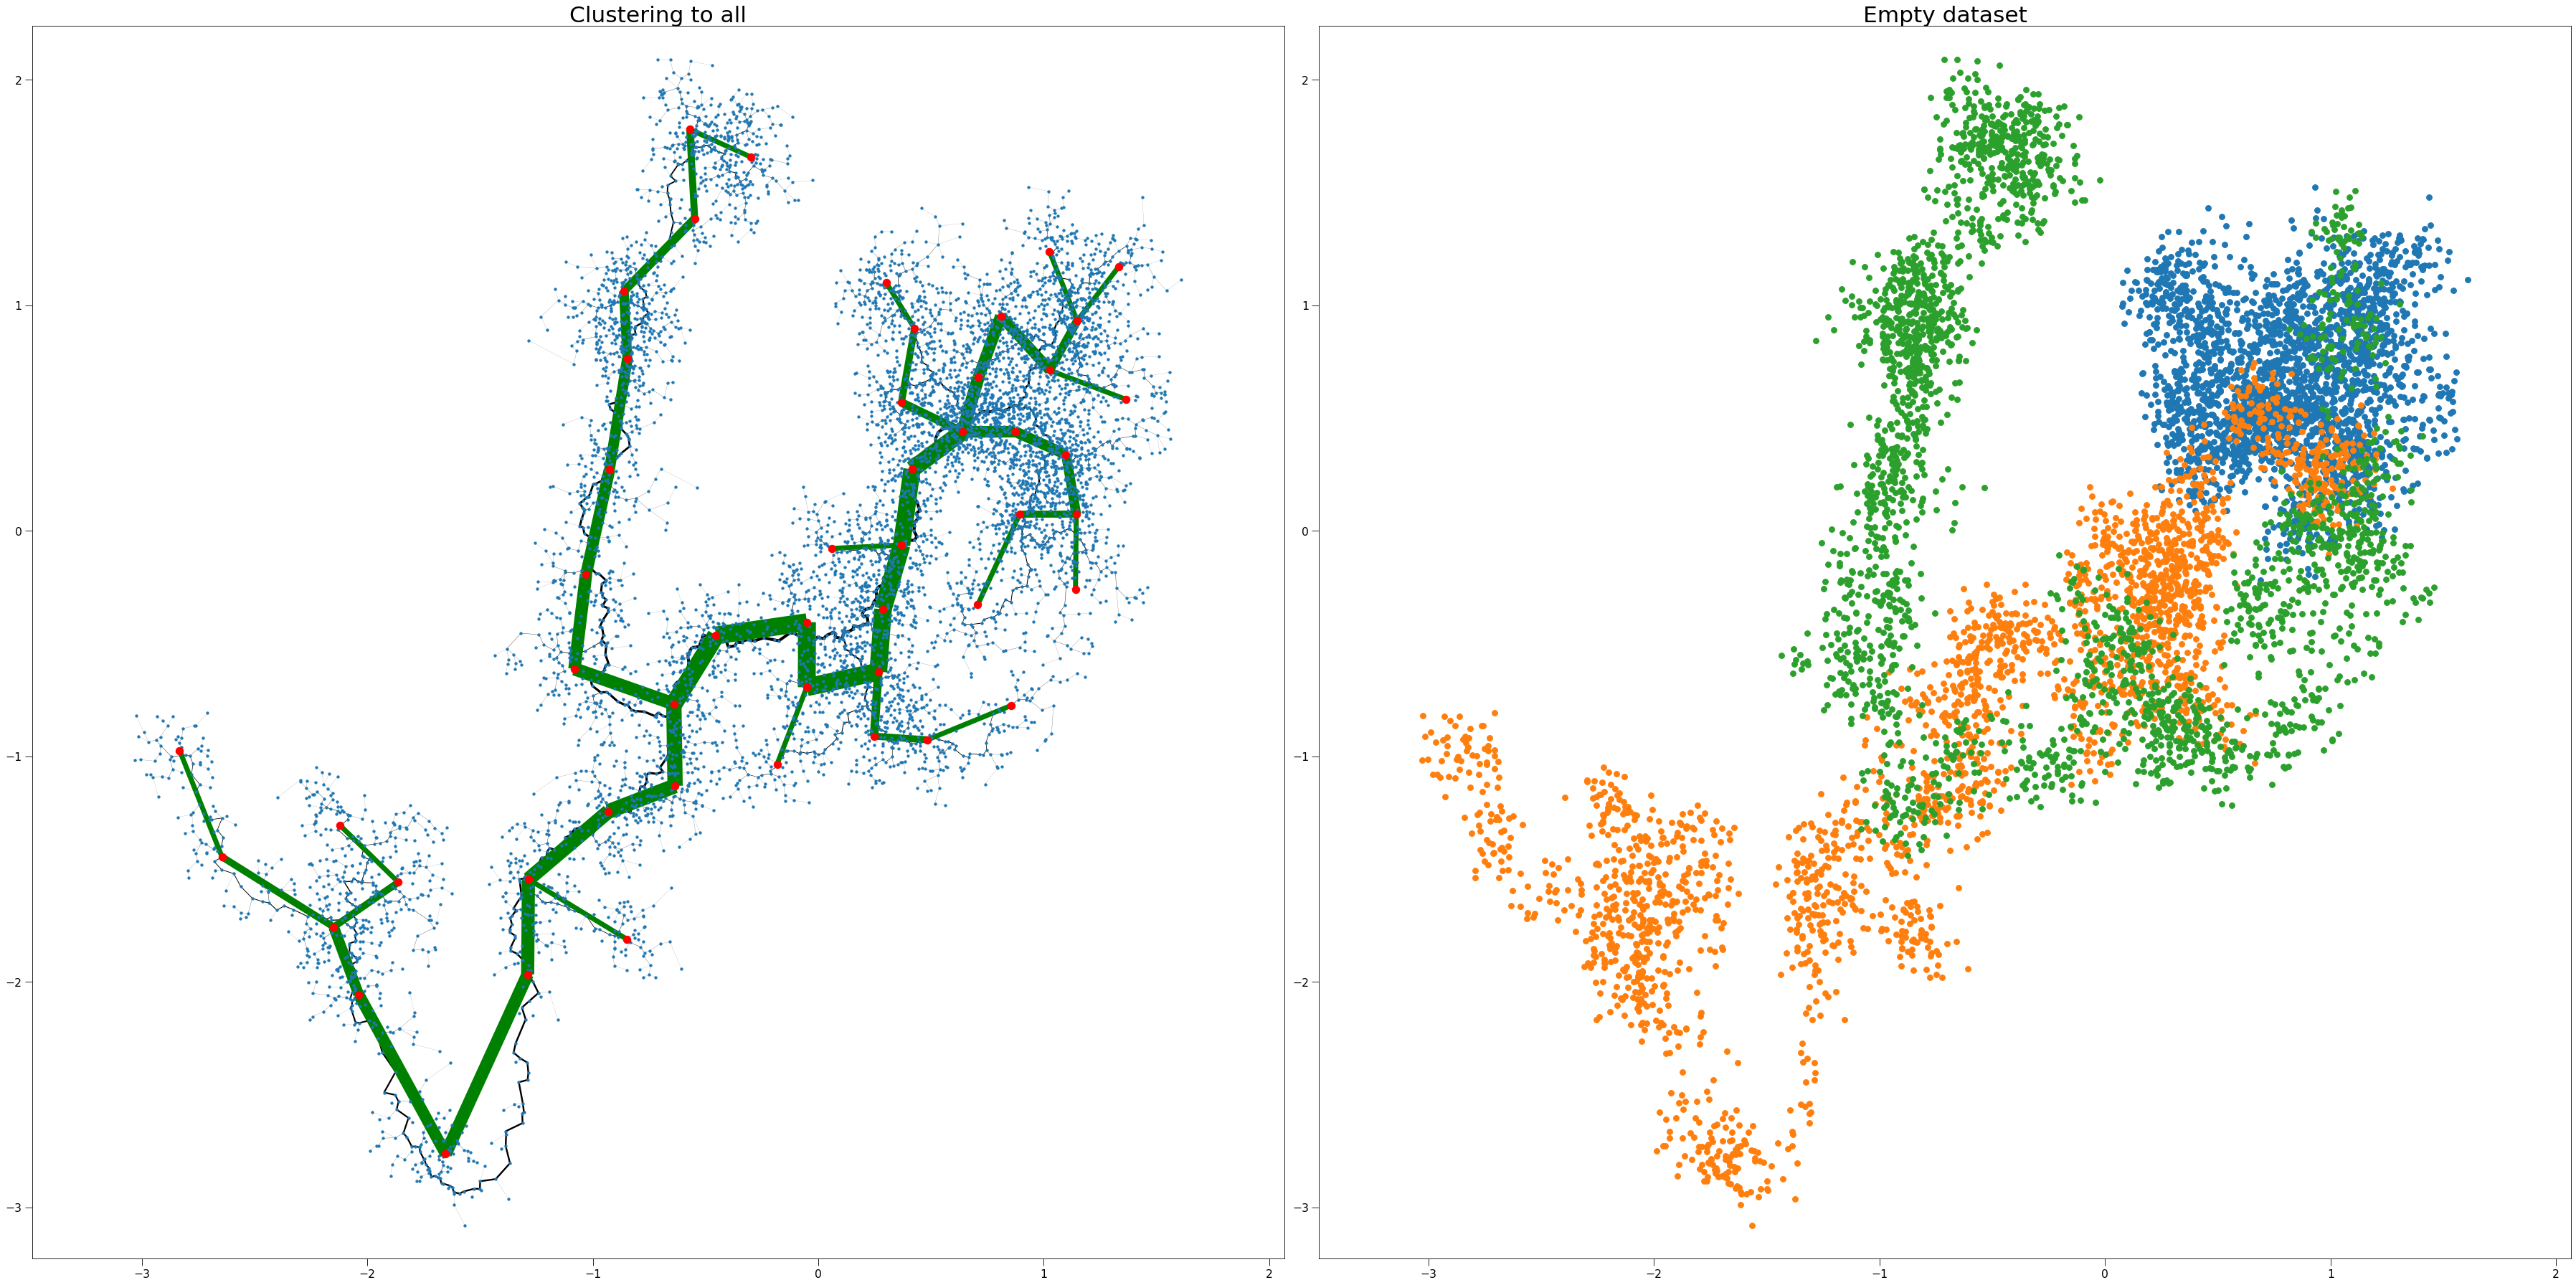

In [121]:
# plotting
graphs = [ICT_cluster_all]
widths = [widths_cluster_all]
names = ["Clustering to all", "Empty dataset"]


number_of_plots = len(names)
fig, ax = plt.subplots(1,2, figsize=(24*2,24))

if number_of_plots == 1:
    ax = [ax]
    
for i in range(number_of_plots):
    if i == 0:
        nk.viztasks.drawGraph(graphs[i], pos=position, ax=ax[i], width=np.array(widths[i])/3, node_size=10)
        nk.viztasks.drawGraph(mst, pos=position[DTAE_centers], ax=ax[i], width=np.array(compute_widths(mst))*2,
                              node_size=100, edge_color="green", node_color="red")
        ax[i].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax[i].set_axis_on()
    else:
        for label in range(len(labels)):
            plt.plot(*position[np.argwhere(labels == label).T[0]].T, label=label)
    ax[i].set_title(names[i])
    ax[i].axis("equal")
    
plt.tight_layout()
plt.show()

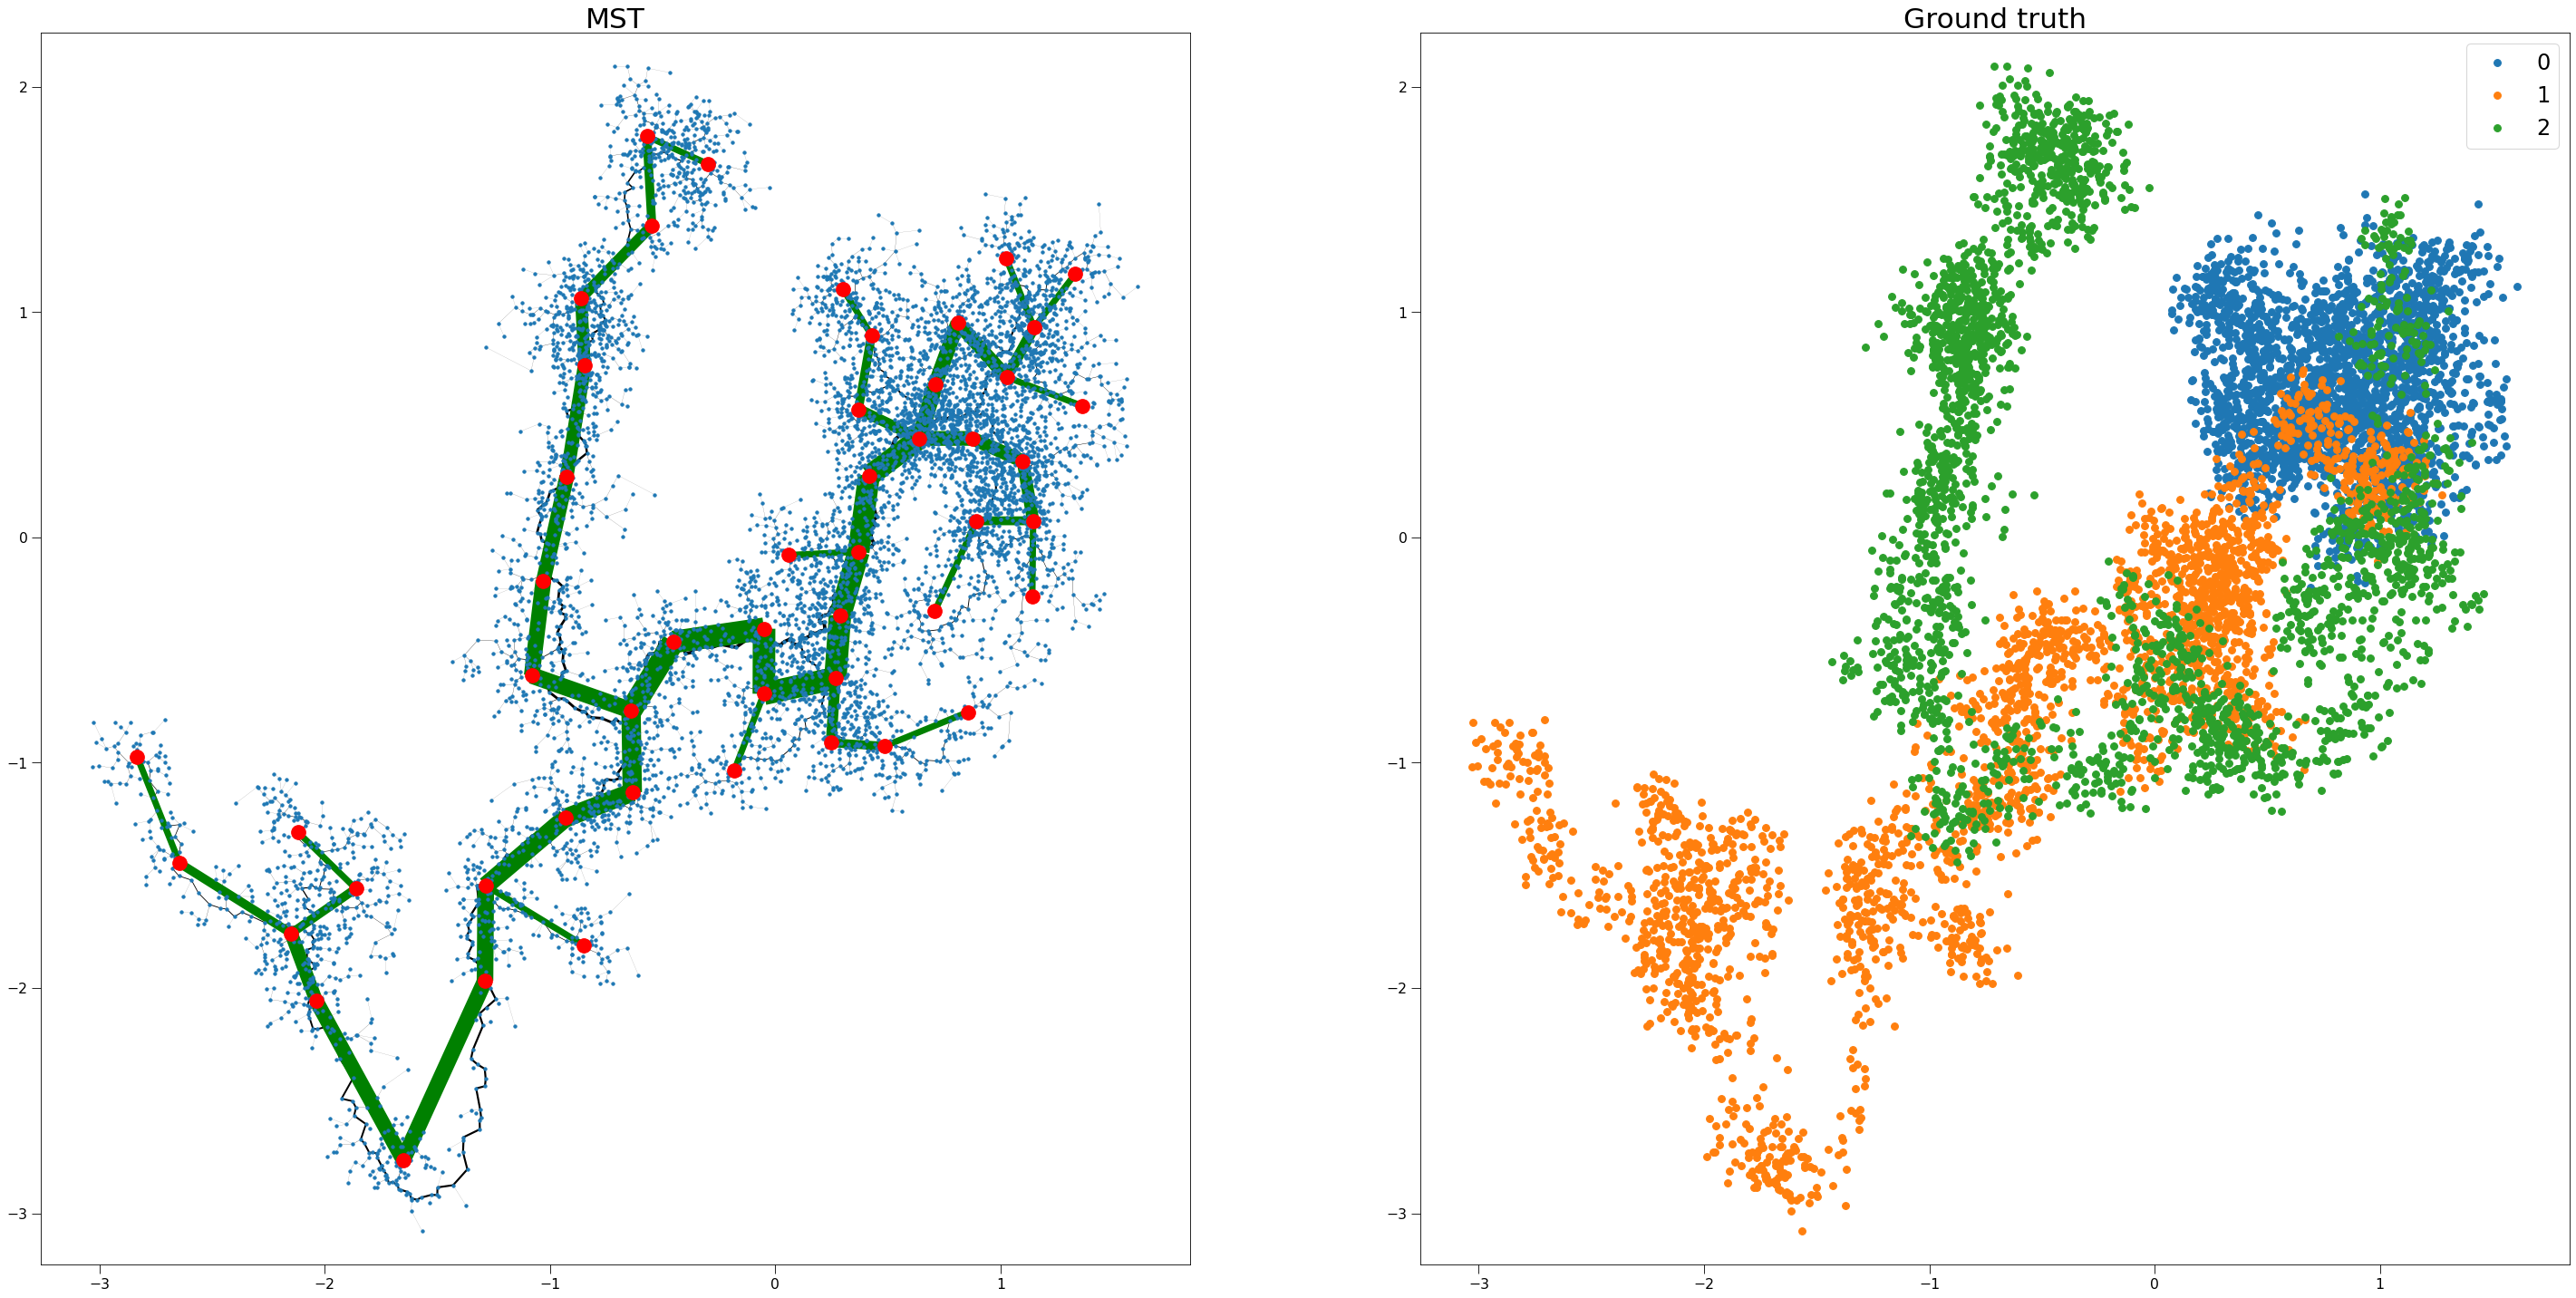

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24*2,24))

plot_graph(ICT_cluster_all, position, "overwritten", ax1, edge_scale=0.3, cluster_centers=DTAE_centers)
plot_graph(mst, position[DTAE_centers], "MST", ax1, edge_scale=2, edge_color="green")
plot_points(position, "Ground truth", ax2, labels)

plt.show()

In [150]:
PC_to_CC = np.load("/net/hcihome/storage/flernst/Data/eth_CC/PC_to_CC.npy")
CA_to_CC = np.load("/net/hcihome/storage/flernst/Data/eth_CC/CA_to_CC.npy")

/net/hcihome/storage/flernst
